## Imports

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/01_raw/en.openfoodfacts.org.products.tsv", sep="\t", low_memory=False)



## Quelques infos sur la DataFrame

In [3]:
print("Taille de la table : {} lignes et {} colonnes.".format(
    df.shape[0], df.shape[1])
)
df.sample(3)

Taille de la table : 356027 lignes et 163 colonnes.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
166650,0857157004012,http://world-en.openfoodfacts.org/product/0857...,usda-ndb-import,1489073981,2017-03-09T15:39:41Z,1489073982,2017-03-09T15:39:42Z,"Hapi Water, Fortified Water Beverage",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
99897,0078895121612,http://world-en.openfoodfacts.org/product/0078...,usda-ndb-import,1489064355,2017-03-09T12:59:15Z,1489064356,2017-03-09T12:59:16Z,Sauce For Spicy Garlic Egg-Plant,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228397,3263859856618,http://world-en.openfoodfacts.org/product/3263...,openfoodfacts-contributors,1379700453,2013-09-20T18:07:33Z,1449429484,2015-12-06T19:18:04Z,Poisson à l'oseille au riz basmati,NaN,300 g,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,-3.0,NaN,NaN


## Visualisation du pourcentage de valeurs manquantes

<AxesSubplot:>

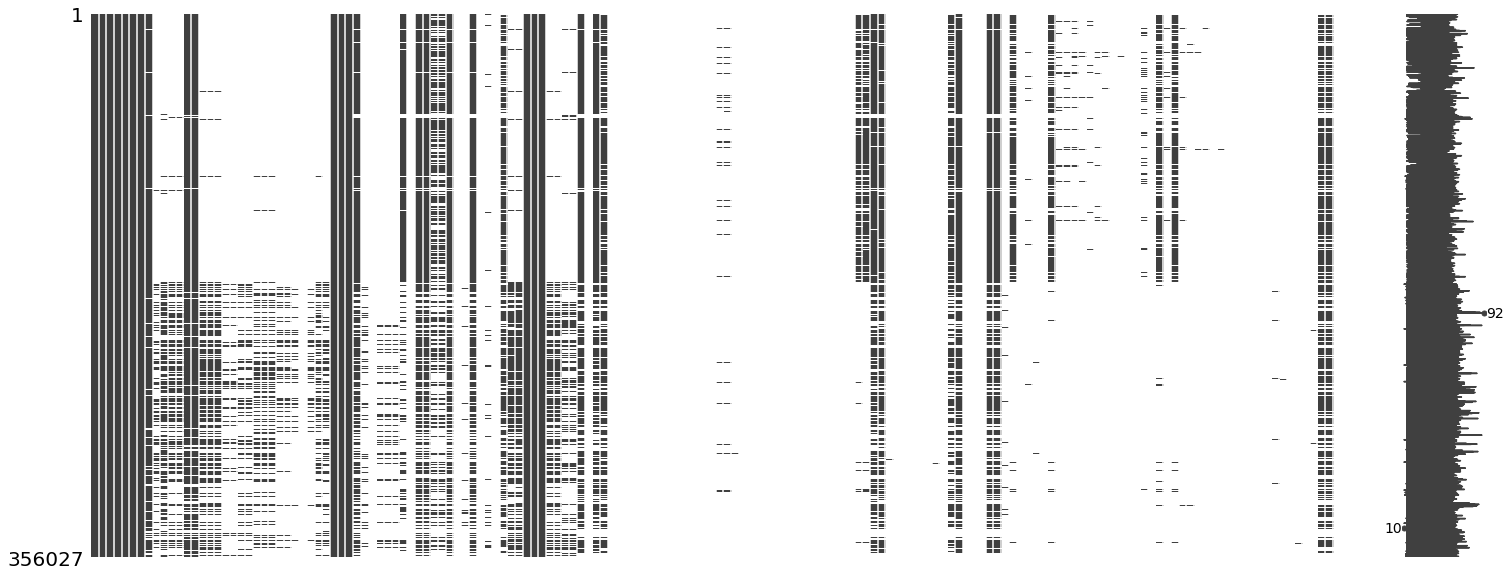

In [4]:
msno.matrix(df)

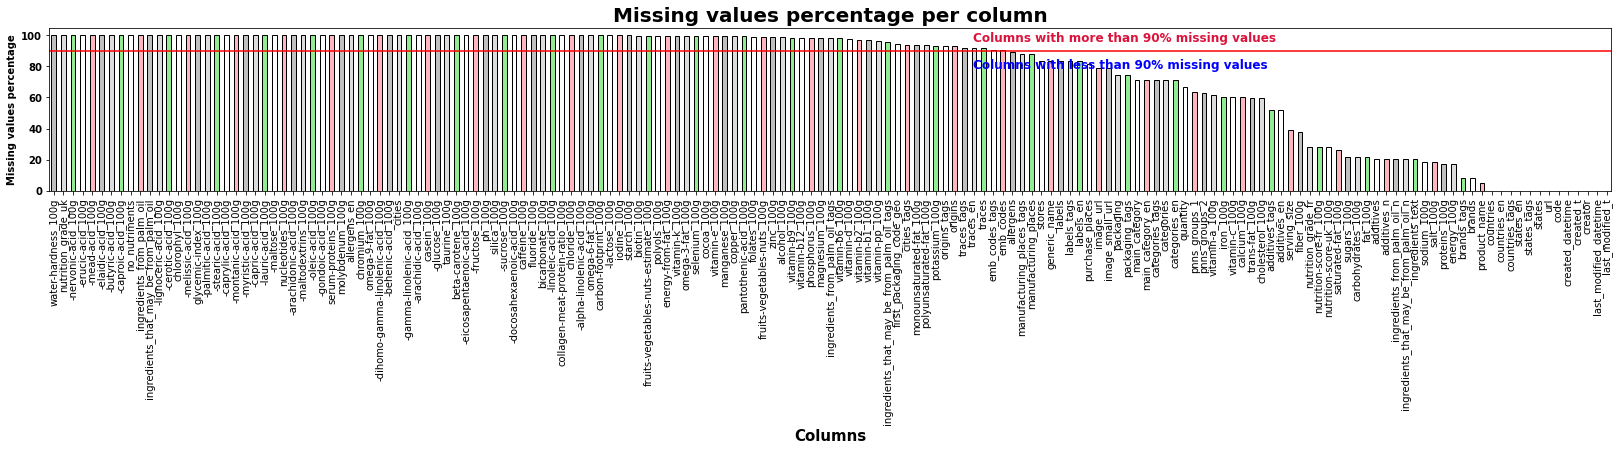

In [5]:
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3):

    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12,weight='bold', color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12,weight='bold', color='blue',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage', weight='bold')
    plt.yticks(weight ='bold')
    
    return plt.show()

msv1(df,90, color=('silver', 'gainsboro', 'lightgreen', 'white', 'lightpink'), width=28, height=3)


## Sélection des entrées concernant uniquement en France

In [6]:
# Vérification de la consistence des données de "countries"
print(df["countries"].value_counts())
print("Plusieurs termes sont utilisés pour définir la France")

# Uniformisation des lignes concernant la France
df["countries"].str.replace(r".*(fr).*", "France", case=False, regex=True)

# Réduction du DataFrame à la France
df = df[df["countries"] == "France"]

US                                               169789
France                                           106296
en:FR                                             16056
Suisse                                            12003
Deutschland                                        6900
                                                  ...  
Tschechien,Deutschland                                1
en:PT, en:france, en:belgium, en:spain,France         1
France,Royaume-Uni,Pays-Bas,Belgique                  1
España, Estados Unidos                                1
France,États-Unis,Suisse                              1
Name: countries, Length: 1637, dtype: int64
Plusieurs termes sont utilisés pour définir la France


## Retrait des lignes sans nom de produit

In [7]:
print(df.product_name.isna().value_counts())
df = df[df.product_name.notna()]

False    105094
True       1202
Name: product_name, dtype: int64


## Sélection des colonnes pertinentes

In [8]:
df = df[
    [
        'product_name',
        'brands',
        'categories',
        'ingredients_text',
        'allergens',
        'nutrition-score-fr_100g',
        'nutrition_grade_fr',
        'energy_100g',
        'fat_100g',
        'saturated-fat_100g',
        'carbohydrates_100g',
        'sugars_100g',
        'fiber_100g',
        'proteins_100g',
        'salt_100g'
    ]
]

## Recherche et suppression de doublons

In [9]:
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    104932
True        162
dtype: int64


## Recherche de données abérantes en ce qui concerne les valeurs énergétiques et traitement de ces données

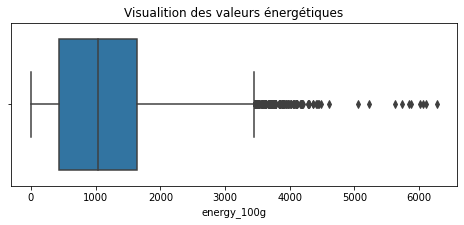

In [10]:
plt.figure(figsize=(8,3))
plt.title("Visualition des valeurs énergétiques")
ax = sns.boxplot(x = df['energy_100g'])

# La valeur énergétique maximale que l'on peut atteindre est d'environ 3700 Kj
df= df[df["energy_100g"] <= 3700]   

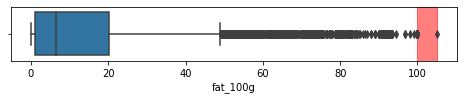

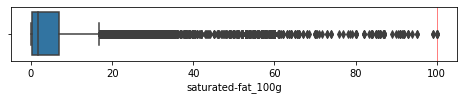

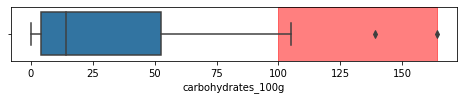

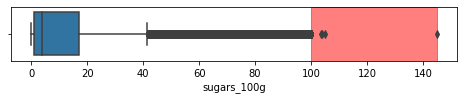

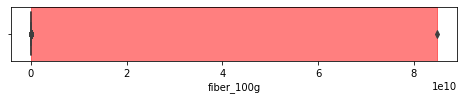

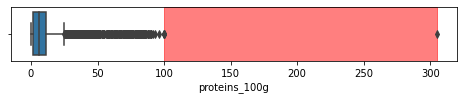

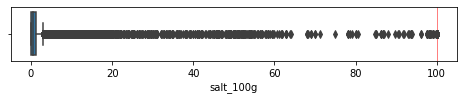

In [11]:
temp_df = df[[
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]]


for i, col in enumerate(temp_df.columns):
    xmax = df[col].max()
    if xmax <= 100:
        xmax = 100
    plt.figure(i, figsize=(8,1))
    plt.axvspan(100,df[col].max(), color='red', alpha=0.5)
    sns.boxplot(x=col, data=temp_df)

## Retrait des valeurs abérantes ( au delà de 100g / 100g)

In [12]:
for col in temp_df:
    df = df[df[col] <= 100]


## Vérification après retrait des valeurs

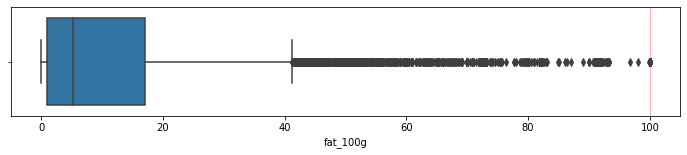

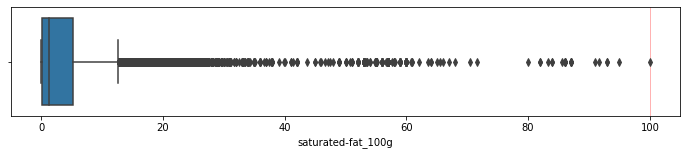

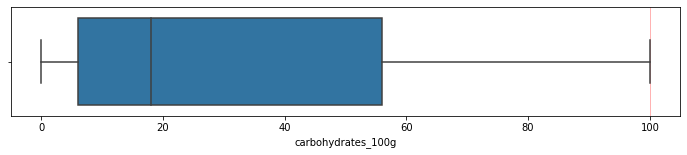

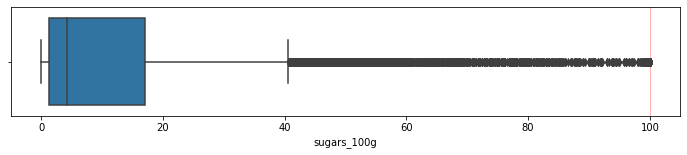

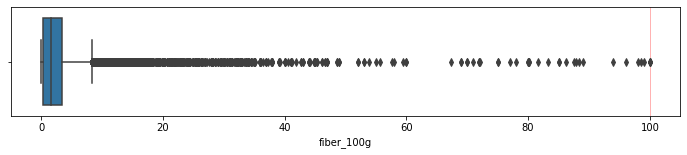

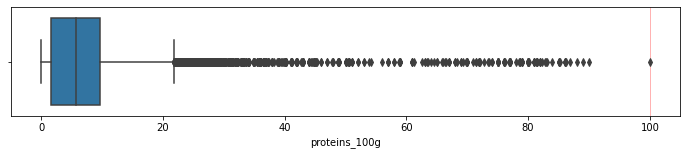

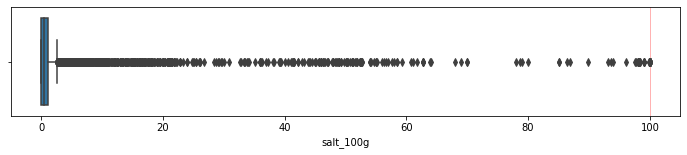

In [13]:
temp_df = df[[
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]]

for i, col in enumerate(temp_df.columns):    
    xmax = df[col].max()
    if xmax <= 100:
        xmax = 100
    plt.figure(i, figsize=(12,2))
    plt.axvspan(100, xmax, color='red', alpha=0.3)
    sns.boxplot(x=col, data=temp_df)

In [14]:
## Traitement des valeurs manquantes

In [15]:
cols =  [
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]
for col in cols:
    df[col].fillna(0.0, inplace=True)
    
cols2 = [
    "categories",
    "ingredients_text",
    "allergens",
    "nutrition_grade_fr",
    'nutrition-score-fr_100g',
    "brands"
]
for col in cols2:
    df[col].fillna("Non renseigné", inplace=True)

## visualisation finale avec missingno

<AxesSubplot:>

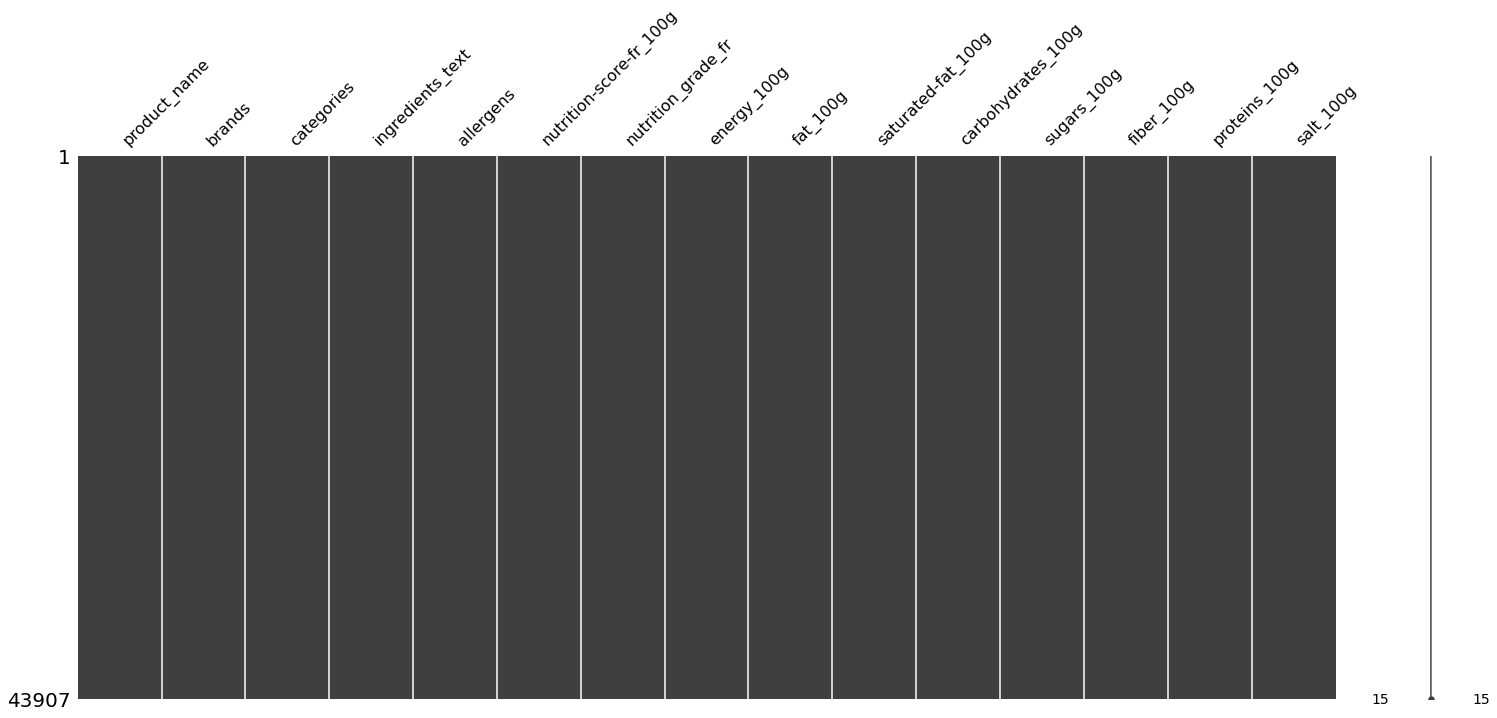

In [16]:
msno.matrix(df)

In [18]:
print("Taille de la table : {} lignes et {} colonnes.".format(
    df.shape[0], df.shape[1])
)

Taille de la table : 43907 lignes et 15 colonnes.
